In [1]:
import numpy as np
import torch
import skimage.io as io
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

1796.5320619607842


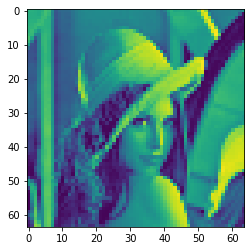

In [3]:
def create_function_data(if_plot= False):
    img = io.imread('1.png', as_gray=True)
    print(img.sum())
    plt.imshow(img)
    
    x = torch.ones(0).float()
    img_mask = np.ones((img.shape[0]//2,img.shape[1]//2))
    for i in range(img.shape[0]//2):
        for j in range(img.shape[1]//2):
            img_mask[i,j] = img[i*2, j*2]
    imgreal = torch.unsqueeze(torch.from_numpy(img_mask), 2).float()
    imgimag = torch.unsqueeze(torch.zeros((32,32)), 2).float()
    y = torch.cat([imgreal, imgimag], 2)
    
    data = {"x":x, "y":y}
    
    return data
    
data = create_function_data(if_plot=True)

In [4]:
rows= 64
cols = 64

class DFT2DRegressionMask(torch.nn.Module):
    """
    DFT Regressoin Module
    """
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, rows*cols)
        self.fc2 = torch.nn.Linear(1, rows*cols)
        self.float()
        
        self.mask = np.zeros((rows,cols))
        for i in range(32):
            for j in range(32):
                self.mask[2*i, 2*j] = 1
        
    def forward(self, x):
        dummy = torch.ones(1).to(dev)
        dummy = torch.unsqueeze(dummy, dim=1)
        
        real = torch.reshape(self.fc1(dummy), (rows,cols))
        imag = torch.reshape(self.fc2(dummy), (rows,cols))
        cplx = torch.complex(real, imag)
        
        mask = torch.from_numpy(self.mask).ge(0.5).to(dev)
        
        result = torch.fft.ifft2(cplx)
        mask_real = torch.reshape(torch.masked_select(torch.real(result), mask), (32,32,1))
        mask_imag = torch.reshape(torch.masked_select(torch.imag(result), mask), (32,32,1))
        out = torch.cat([mask_real, mask_imag], 2)
        
        return out

In [5]:
class DFT2DMask_Model():
    def __init__(self):
        """
        Initialize the DFT 2D Model
        """
        self.learning_rate = 10000
        self.epoches = 10000
        self.loss_function = torch.nn.MSELoss()
        self.create_model()
        
    def create_model(self):
        self.model = DFT2DRegressionMask().to(dev)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
    
    def train(self, data, model_save_path="model.pth"):
        """
        Train the model and save the parameters
        Args:
            model_save_path: saved name of model
            data: (x, y) = data
        Returns: 
            None
        """
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        for epoch in range(self.epoches):
            prediction = self.model(x)
            loss = self.loss_function(prediction, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % 500 == 0:
                print("epoch: {}, loss is: {}".format(epoch, loss.item()))
        torch.save(self.model.state_dict(), "dft2d.pth")      
        
    def test(self, x, model_path="dft2d.pth"):
        """
        Reload and test the model, plot the prediction
        Args:
            model_path: the model's path and name
            data: (x, y) = data
        Returns:
            None
        """
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        self.model.load_state_dict(torch.load(model_path))
        prediction = self.model(x)
        
        pred = prediction.detach().cpu().numpy()
        
        fig = plt.figure(figsize=(10,10))
        print(pred[:,:,0].max(), pred[:,:,0].min())
        print(pred[:,:,1].max(), pred[:,:,1].min())
        plt.subplot(1, 2, 1)
        plt.imshow(pred[:,:,0])
        plt.subplot(1, 2, 2)
        plt.imshow(pred[:,:,1])
        
    def compare_epoches(self, data):
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        
        num_pictures = 16
        fig = plt.figure(figsize=(10,10))
        current_fig = 0
        for epoch in range(self.epoches):
            prediction = self.model(x)
            loss = self.loss_function(prediction, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if epoch % (self.epoches/num_pictures) == 0:
                current_fig += 1
                plt.subplot(4, 4, current_fig)
                pred = prediction.detach().cpu().numpy()
                plt.imshow(pred[:,:,0])
        plt.show()

1796.5320619607842
epoch: 0, loss is: 0.11522059887647629
epoch: 500, loss is: 0.0009676043409854174
epoch: 1000, loss is: 8.125749445753172e-06
epoch: 1500, loss is: 6.823554343782234e-08
epoch: 2000, loss is: 5.782001544218929e-10
epoch: 2500, loss is: 6.324575411997824e-12
epoch: 3000, loss is: 6.002137589028456e-12
epoch: 3500, loss is: 5.958713123616066e-12
epoch: 4000, loss is: 5.947754441737452e-12
epoch: 4500, loss is: 5.9414812479674506e-12
epoch: 5000, loss is: 5.955804426027722e-12
epoch: 5500, loss is: 5.956703446469147e-12
epoch: 6000, loss is: 5.957695274616537e-12
epoch: 6500, loss is: 5.94673746009966e-12
epoch: 7000, loss is: 5.952618172683222e-12
epoch: 7500, loss is: 5.958041785630863e-12
epoch: 8000, loss is: 5.9587686347672975e-12
epoch: 8500, loss is: 5.9428330312361055e-12
epoch: 9000, loss is: 5.940861951686527e-12
epoch: 9500, loss is: 5.953445635781263e-12
0.8523268 0.08443427
3.7021672e-07 -4.013967e-07


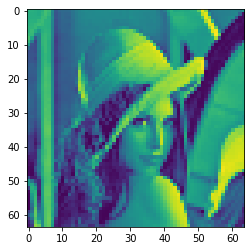

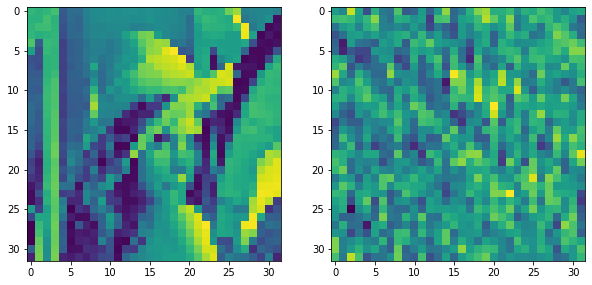

In [6]:
dft2d = DFT2DMask_Model()
data = create_function_data()
dft2d.train(data)
dft2d.test(data)

In [7]:
class DFT2DRegression(torch.nn.Module):
    """
    DFT Regressoin Module
    """
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, rows*cols)
        self.fc2 = torch.nn.Linear(1, rows*cols)
        self.float()
        
    def forward(self, x):
        dummy = torch.ones(1).to(dev)
        dummy = torch.unsqueeze(dummy, dim=1)
        
        real = torch.reshape(self.fc1(dummy), (rows,cols))
        imag = torch.reshape(self.fc2(dummy), (rows,cols))
        cplx = torch.complex(real, imag)
        
        result = torch.fft.ifft2(cplx)
        real = torch.reshape(torch.real(result), (64,64,1))
        imag = torch.reshape(torch.imag(result), (64,64,1))
        out = torch.cat([real, imag], 2)
        
        return out

In [8]:
class DFT2D_Model():
    def __init__(self):
        """
        Initialize the DFT 2D Model
        """
        self.learning_rate = 10000
        self.epoches = 10000
        self.loss_function = torch.nn.MSELoss()
        self.create_model()
        
    def create_model(self):
        self.model = DFT2DRegression().to(dev)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
    
    def train(self, data, model_save_path="model.pth"):
        """
        Train the model and save the parameters
        Args:
            model_save_path: saved name of model
            data: (x, y) = data
        Returns: 
            None
        """
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        for epoch in range(self.epoches):
            prediction = self.model(x)
            loss = self.loss_function(prediction, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % 500 == 0:
                print("epoch: {}, loss is: {}".format(epoch, loss.item()))
        torch.save(self.model.state_dict(), "dft2d.pth")      
        
    def test(self, x, model_path="dft2d.pth"):
        """
        Reload and test the model, plot the prediction
        Args:
            model_path: the model's path and name
            data: (x, y) = data
        Returns:
            None
        """
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        self.model.load_state_dict(torch.load(model_path))
        prediction = self.model(x)
        
        pred = prediction.detach().cpu().numpy()
        
        fig = plt.figure(figsize=(10,10))
        print(pred[:,:,0].max(), pred[:,:,0].min())
        print(pred[:,:,1].max(), pred[:,:,1].min())
        plt.subplot(1, 2, 1)
        plt.imshow(pred[:,:,0])
        plt.subplot(1, 2, 2)
        plt.imshow(pred[:,:,1])
        
    def compare_epoches(self, data):
        x = data["x"].to(dev)
        y = data["y"].to(dev)
        
        num_pictures = 16
        fig = plt.figure(figsize=(10,10))
        current_fig = 0
        for epoch in range(self.epoches):
            prediction = self.model(x)
            loss = self.loss_function(prediction, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if epoch % (self.epoches/num_pictures) == 0:
                current_fig += 1
                plt.subplot(4, 4, current_fig)
                pred = prediction.detach().cpu().numpy()
                plt.imshow(pred[:,:,0])
        plt.show()

1796.5320619607842
0.8523268 -0.04961279
0.046032883 -0.045839276


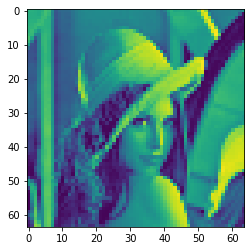

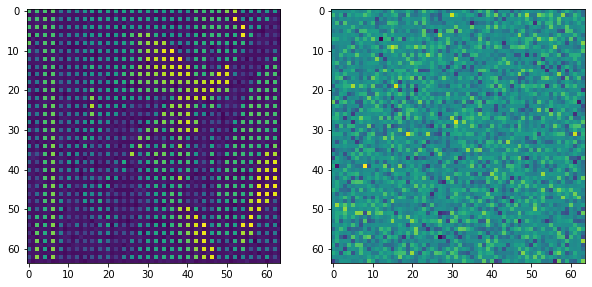

In [9]:
dft2d = DFT2D_Model()
data = create_function_data()
dft2d.test(data)